In [1]:
from collections import Counter
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as st
import seaborn as sns

plt.close('all')
sns.set(color_codes=True)
matplotlib.rc("font", size=20)
matplotlib.rc("xtick", labelsize=20)
matplotlib.rc("ytick", labelsize=20)
matplotlib.rc("axes", labelsize=24)
matplotlib.rc("axes", titlesize=28)
matplotlib.rc("legend", fontsize=14)
matplotlib.rc("figure", titlesize=24)

from Problem2_4_ImageProcessingPackage import *

cmap = sns.color_palette()

%matplotlib inline

In [2]:
def get_eCDF(X, extend=False, padFactor=0.02):
    """Creates an empirical CDF for input data X.  Pads CDF for plotting.
    
    Created by Eric Johnson
    Edited on October 12, 2020
    
    This is a function I put together because I was making a lot of eCDFs
    and I wanted to sometimes pad them for plotting.
    
    Inputs
    ======
    X           (array-like) Data whose eCDF is to be calculated.
    extend      (bool) Keyword indicating whether to add values to the 
                eCDF outside of the observed range while storing a 0 and
                1 as the eCDF quantiles.  This creates a slightly longer
                list that may be preferable for plotting.
    padFactor   (float) The fraction of the total range to extend the 
                values to.  If extend=False, this does nothing.
                
    Outputs
    =======
    vals        (np.ndarray) Array of observed values in 'X'.  The values
                are sorted from smallest to largest.  This array will 
                contain the number of unique elements in 'X' numbers. If
                extend=True, it will contain a smaller and larger value,
                corresponding to CDF = 0 and 1, respectively.
    CDF         (np.ndarray) Array of quantiles indicating what fraction 
                of the data have been observed to be less than or equal
                to the corresponding value in 'vals'.  This array will 
                contain the number of unique elements in 'X' numbers. If
                extend=True, it will contain a smaller and larger value,
                corresponding to CDF = 0 and 1, respectively.
    """
    
    counts = Counter(np.array(X).astype(float).ravel())
    vals = np.array(np.msort(list(counts.keys()))).squeeze()
    CDF = np.cumsum([counts[v] for v in vals])
    
    pad = np.abs(padFactor*(vals[-1] - vals[0]))

    CDF = CDF / CDF[-1]
    
    if extend:
        vals = np.array([vals[0]-pad] + 
                         list(vals.ravel()) +
                        [vals[-1] + pad])
        CDF = np.array([0] + list(CDF.ravel()) + [1])
        
    return vals, CDF

# Assignment 2 Question 4
As explained in the course notes, in [this 2011 paper](https://www.dropbox.com/s/9inxgf59wd0322h/Garcia2011c.pdf?dl=0) by Garcia and Phillips, the authors develop a model based on the principles of thermodynamics in order to measure the number of LacI repressors present in different strains of \textit{E. coli}, as well as the binding energy of those repressors.  In Figure S8 of their paper, they show how given estimates for the number of repressors, $R$, they can use their model, given in Equation 5 of the paper:
\begin{equation}
    \text{Fold Change in YFP Fluorescence} = \left(
        1 + \frac{2R}{N_{NS}}e^{-\beta\Delta\varepsilon_{RD}}
    \right)^{-1}
\end{equation}
to generate an estimate for the binding energy of those repressors, $\Delta\varepsilon_{RD}$.  As given in the notes and the paper, $N_{NS} = 5\times10^6$, is the number of Non-Specific DNA binding sites for repressors and RNA Polymerase, and $\beta = 1/k_BT$ is a shorthand factor that  contains the Boltzmann constant.

## 4.a.

You may or may not be surprised to learn that a common experimental technique for measuring cellular activity is to *take pictures* of cells at specific wavelengths of light.  This measures activity because the cells have been modified so that specific proteins fluoresce at specific wavelengths.  What this looks like then is the images in [this folder](https://www.dropbox.com/sh/twqgn2md9ktsuiy/AACc84ApoZ6fvdwqcu4KgjC_a?dl=0).  In each of these images, a specific strain of bacteria has been imaged at a couple wavelengths (a yellow one and a red one), and the idea is that the amount of light (number of photons) measured at those wavelengths directly corresponds to how much of a desired protein (LacI) exists in the cells or their environment.

Using the functions in the script [here](https://www.dropbox.com/s/wiexvtu7395cpbn/Problem2_4_ImageProcessingPackage.py?dl=0), you will assemble lists of the YFP fluorescence of the cells in [these `tif` images](https://www.dropbox.com/sh/twqgn2md9ktsuiy/AACc84ApoZ6fvdwqcu4KgjC_a?dl=0).  In this folder, there are 7 strains of \textit{E. coli} that have various mutations to the lacI repressor.  The `Auto` strain is the "wild-type" control, and the `Delta` strain is one in which the lacI repressor has been knocked-out (it has no lacI repressors at all).  
            
Recall that you can import functions from any Python script using the command `from myFile import *`, where `myFile` is whatever you named the file in the link above.  In this notebook, I'll walk you through how the functions in that script can be used to extract the YFP fluorescence from the images.

First, let's look at the functions available in our script.  Using the `help(function)` syntax we uncover the following:

- `strainFileFinder`: This function appears to be a bookkeeping/helper function that *finds* the images we want in a file structure.  Writing such functions can be useful sometimes when working across many directories or with many experimental conditions.
- `channelPlotter`: This function takes in file paths to `.tif` images and plots them.
- `channelPixelDistPlotter`: This function takes in an image file path and plots the *distribution* of pixels.
- `getYFP_Image`: This is the first function that does some heavy lifting.  Specifically, this function takes in a YFP image and an mCherry or Phase-Contrast image and extracts the YFP fluorescence of the detected cells.
- `getYFP_AllStrains`: This function applies `getYFP_Image` recursively to all the sets of images in the directory.
- `calcFoldChange`: This function uses the extracted output from `getYFP_AllStrains` to determine the *fold-change* in expression for each of the strains.
- `saveFigure`: This is another utility function for saving figures quickly in a couple different file formats.

As a demonstration, I will show how each of these functions gets used in a manner similar to the example at the bottom of the `Problem2_4_ImageProcessingPackage.py` file.

In [3]:
## First let's look at the 'Auto' strain, which is an image where there
## are no YFP-tagged proteins.
YFPPaths, mChrPaths, PhasePaths = strainFileFinder('Auto')

print("The YFP file paths are:")
for path in YFPPaths:
    print(f"\t{path}")
    
print("\nThe mCherry file paths are:")
for path in mChrPaths:
    print(f"\t{path}")
    
print("\nThe Phase-Contrast file paths are:")
for path in PhasePaths:
    print(f"\t{path}")

The YFP file paths are:
	Phillips_Garcia_Data/laci_full_set/Auto/YFP_regulated_1.tif
	Phillips_Garcia_Data/laci_full_set/Auto/YFP_regulated_2.tif
	Phillips_Garcia_Data/laci_full_set/Auto/YFP_regulated_3.tif
	Phillips_Garcia_Data/laci_full_set/Auto/YFP_regulated_4.tif

The mCherry file paths are:
	Phillips_Garcia_Data/laci_full_set/Auto/mCherry_constitutive_1.tif
	Phillips_Garcia_Data/laci_full_set/Auto/mCherry_constitutive_2.tif
	Phillips_Garcia_Data/laci_full_set/Auto/mCherry_constitutive_3.tif
	Phillips_Garcia_Data/laci_full_set/Auto/mCherry_constitutive_4.tif

The Phase-Contrast file paths are:
	Phillips_Garcia_Data/laci_full_set/Auto/Phase_1.tif
	Phillips_Garcia_Data/laci_full_set/Auto/Phase_2.tif
	Phillips_Garcia_Data/laci_full_set/Auto/Phase_3.tif
	Phillips_Garcia_Data/laci_full_set/Auto/Phase_4.tif


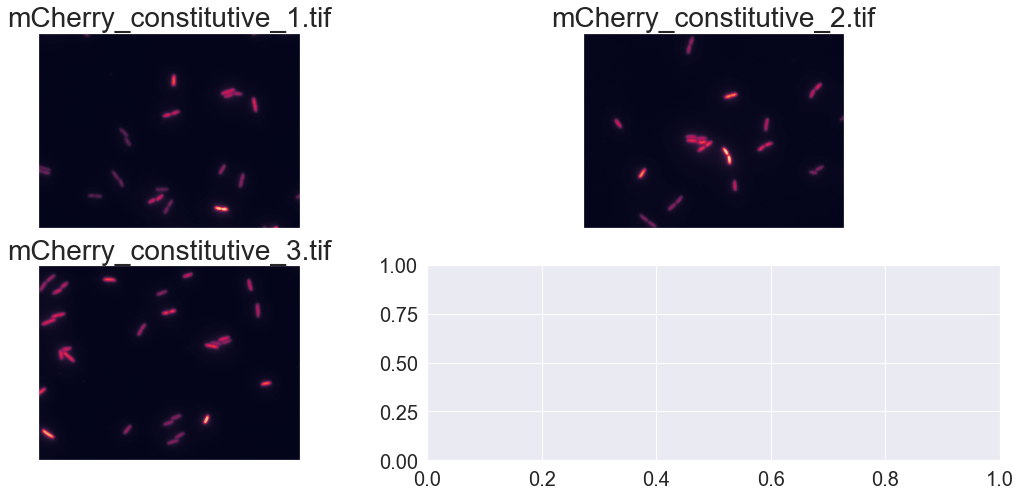

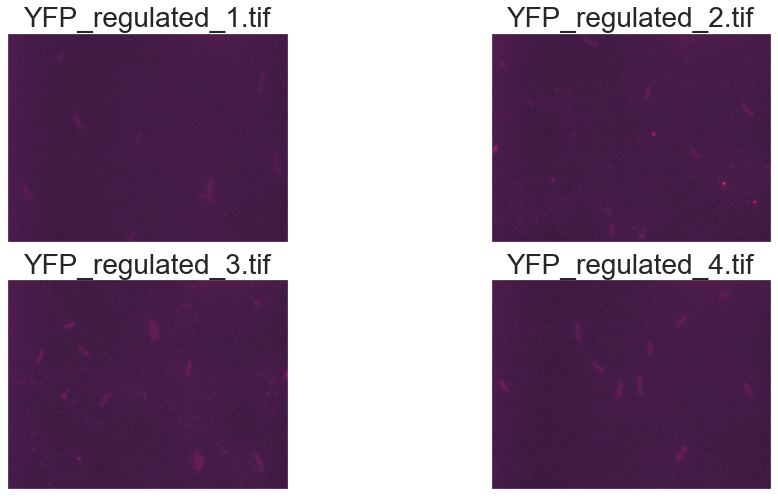

In [4]:
## After this, let's test these plotting utilities, let's load the 'Delta' strain as well.
YFPDeltaPaths, mChrDeltaPaths, PhaseDeltaPaths = strainFileFinder('Delta')

## Let's look at the mCherry images from the Delta strain
channelPlotter(mChrDeltaPaths);

## Then the YFP images from the Auto strain
channelPlotter(YFPPaths);

/Users/EricJohnson/opt/anaconda3/envs/QBioCourse/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/EricJohnson/opt/anaconda3/envs/QBioCourse/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


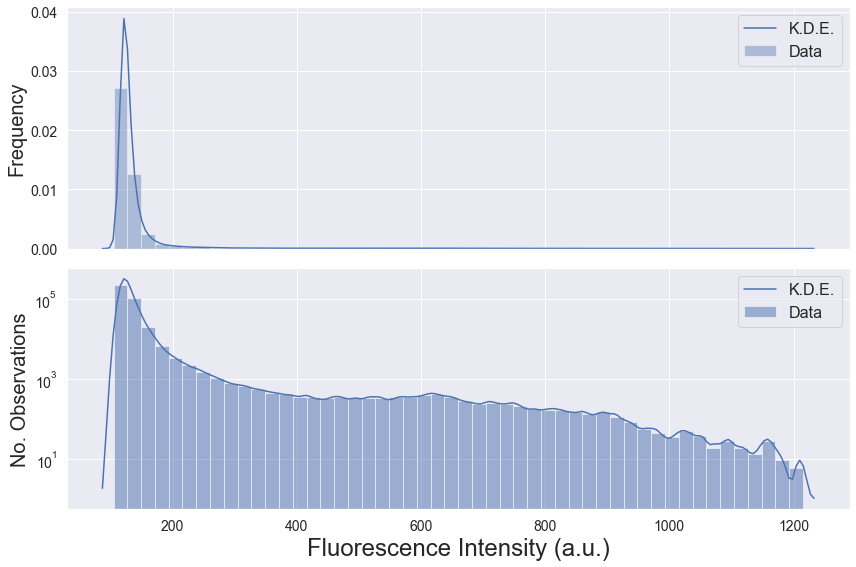

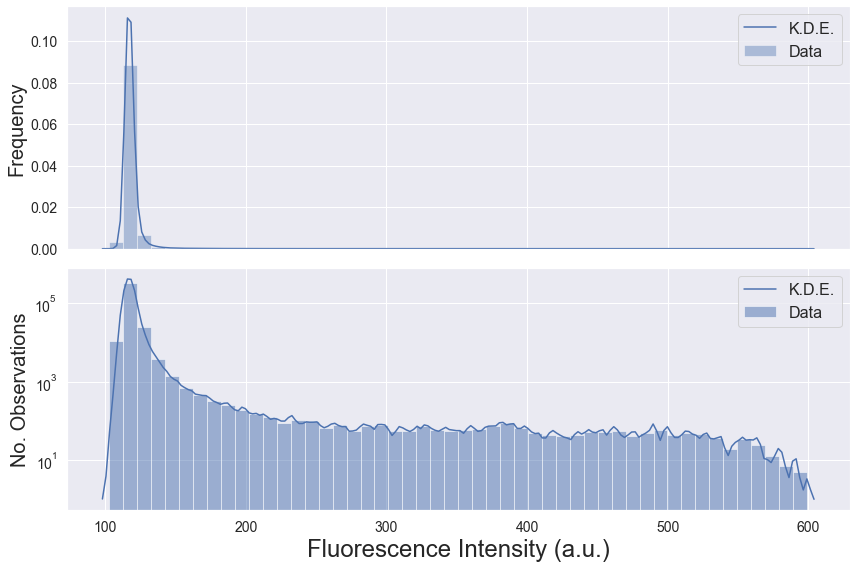

In [5]:
## Then let's try the distribution plotter.
## NOTICE that the LOG-TRANSFORMED distribution shows the tail of 
## the distribution much more clearly!

## YFP of the Delta strain
channelPixelDistPlotter(YFPDeltaPaths[0]);

## mCherry of the Auto strain
channelPixelDistPlotter(mChrPaths[1]);

/Users/EricJohnson/opt/anaconda3/envs/QBioCourse/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


YFPMean = 
626.6381787048607

Looking at the 'blobs'... What are they??

blobs = 
[<skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4ca0>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4d30>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4d00>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4c70>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4cd0>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4d60>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4d90>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4dc0>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4df0>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4e20>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4e50>, <skimage.measure._regionprops.RegionProperties object at 0x7fc672bb4e80>, <skimage.measure._regionprops

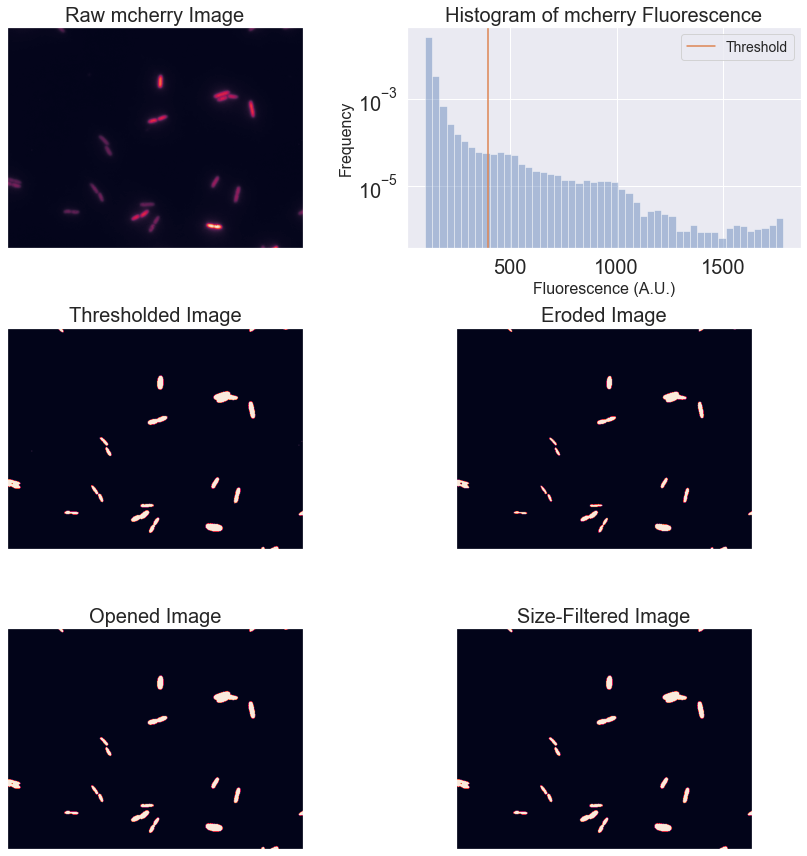

In [6]:
## Finally, let's try processing some images.

## We need to load the images as arrays from the path.
## Using the first YFP and mCherry image from the delta strain.
YFPImg = plt.imread(YFPDeltaPaths[0])
mChrImg = plt.imread(mChrDeltaPaths[0])

[YFPMean, blobs, labelImg, fig_h] = getYFP_Image(YFPImg, mChrImg, 
                                                 "mCherry", 
                                                 show_plots=True)

print("YFPMean = ")
print(YFPMean)

print("\nLooking at the 'blobs'... What are they??\n\nblobs = ")
print(blobs)

Let's unpack what just happened.  This function took in two images, a YFP image and an mCherry image.  The mCherry image was then thresholded (picking a threshold by looking at the distribution), and this binarized image had some other stuff happen to it until we get the bottom right panel, where we see white blobs that look like the correspond to the bacteria in the original image (top left).  We then use the locations of these blobs to get the YFP values  *from the YFP image*.  From this we get a mean YFP value for the image, but we also get a list of `skimage.measure.region_props` objects that we have called `blobs`.  This is because we can use **segmentation** to find each *unique* blob that is separated from the others.  The properties of these "blobs" are stored in these objects, and include things such as the area, centroid, and label of the individual regions.

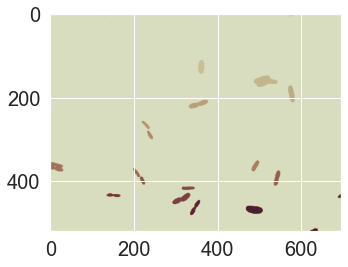

In [7]:
import pandas as pd
from skimage.measure import regionprops_table

## This is a function that can be useful for aggregating certain region properties
blobprops = regionprops_table(labelImg, properties=['area', 'bbox', 'centroid',
                                                    'extent', 'label'])

## Converting to a Pandas data frame for visualization.
blobDF = pd.DataFrame(blobprops)
blobDF.index.name = "Blob Number"

blobDF

## If we plot the **LABEL IMAGE** we see each of the bacteria in 
## a different color because each has a different *label*.  
## I've used a custom colormap so you can see more easily.
myCmap = sns.cubehelix_palette(as_cmap=True, start=0.5)
plt.imshow(labelImg, cmap=myCmap)

Now that we've seen how this works, we can use `getYFP_AllStrains` to get all the info from all the strains.

In [8]:
strainInfo = getYFP_AllStrains()


Looking at strain 'Auto'...
Finding files...

	Replicate 0 has mean YFP = 120.27

	Replicate 1 has mean YFP = 122.57

	Replicate 2 has mean YFP = 123.31

	Replicate 3 has mean YFP = 122.78

Looking at strain 'Delta'...
Finding files...

	Replicate 0 has mean YFP = 626.64

	Replicate 1 has mean YFP = 655.76

	Replicate 2 has mean YFP = 629.05

Looking at strain 'HG104'...
Finding files...

	Replicate 0 has mean YFP = 208.63

	Replicate 1 has mean YFP = 218.52

	Replicate 2 has mean YFP = 242.12

	Replicate 3 has mean YFP = 217.83

Looking at strain 'RBS1'...
Finding files...

	Replicate 0 has mean YFP = 129.39

	Replicate 1 has mean YFP = 130.12

	Replicate 2 has mean YFP = 127.7

	Replicate 3 has mean YFP = 129.67

Looking at strain 'RBS1027'...
Finding files...

	Replicate 0 has mean YFP = 134.77

	Replicate 1 has mean YFP = 136.37

	Replicate 2 has mean YFP = 137.37

	Replicate 3 has mean YFP = 135.02

Looking at strain 'RBS1147'...
Finding files...

	Replicate 0 has mean YFP = 165.

We want to look at the histogram of YFP values, so let's actually extract each blob's YFP value.  `strainInfo` is a nested set of dictionaries keyed by `strain`:`image number`.  So if we want to get the blobs from the second image of the 'Delta' strain, we would use `strainInfo['Delta'][1]['blobs']`.  To get all the YFP, we'll loop through each layer of the dict.

In [9]:
YFPDict = {}  ## Set up our output dictionary
for strain in strainInfo:
    print(f"\nExtracting YFP from {strain}.")
    
    ## Skip fields that aren't strains
    if strain == 'Background':
        continue
    
    ## Set up each strain's YFP list.
    ## We use a list because we don't know how many cells there will be.
    YFPDict[strain] = []
    for imgNo in strainInfo[strain]:
        print(f"Extracting YFP from image number {imgNo}.")
        
        for blob in strainInfo[strain][imgNo]['blobs']:
            ## Save the cell's YFP
            YFPDict[strain].append(blob.YFP)


Extracting YFP from Background.

Extracting YFP from Auto.
Extracting YFP from image number 0.
Extracting YFP from image number 1.
Extracting YFP from image number 2.
Extracting YFP from image number 3.

Extracting YFP from Delta.
Extracting YFP from image number 0.
Extracting YFP from image number 1.
Extracting YFP from image number 2.

Extracting YFP from HG104.
Extracting YFP from image number 0.
Extracting YFP from image number 1.
Extracting YFP from image number 2.
Extracting YFP from image number 3.

Extracting YFP from RBS1.
Extracting YFP from image number 0.
Extracting YFP from image number 1.
Extracting YFP from image number 2.
Extracting YFP from image number 3.

Extracting YFP from RBS1027.
Extracting YFP from image number 0.
Extracting YFP from image number 1.
Extracting YFP from image number 2.
Extracting YFP from image number 3.

Extracting YFP from RBS1147.
Extracting YFP from image number 0.
Extracting YFP from image number 1.
Extracting YFP from image number 2.
Extra

In [10]:
newStrainInfo = strainInfo.copy()  ## Make a copy...
newStrainInfo = calcFoldChange(newStrainInfo)


The average YFP with no repressors is 519.08
The average YFP background is 118.06

The average YFP in HG104 is 221.77
The fold change expression of YFP is 0.1998

The average YFP in RBS1 is 129.22
The fold change expression of YFP is 0.021486

The average YFP in RBS1027 is 135.88
The fold change expression of YFP is 0.034325

The average YFP in RBS1147 is 164.63
The fold change expression of YFP is 0.089707

The average YFP in RBS446 is 152.93
The fold change expression of YFP is 0.067161


In [11]:
strainInfo

{'Background': array([[114, 126, 122, ..., 120, 119, 121],
        [113, 128, 121, ..., 118, 119, 119],
        [114, 126, 120, ..., 118, 118, 118],
        ...,
        [111, 126, 119, ..., 116, 116, 117],
        [108, 124, 118, ..., 118, 118, 117],
        [111, 127, 120, ..., 117, 114, 118]], dtype=uint16),
 'Auto': {0: {'YFPMean': 120.26698972241964,
   'blobs': [<skimage.measure._regionprops.RegionProperties at 0x7fc675bce460>,
   'Img': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]])},
  1: {'YFPMean': 122.56736602892938,
   'blobs': [<skimage.measure._regionprops.RegionProperties at 0x7fc675bcefd0>,
   'Img': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0,

In [12]:
newStrainInfo

{'Background': array([[114, 126, 122, ..., 120, 119, 121],
        [113, 128, 121, ..., 118, 119, 119],
        [114, 126, 120, ..., 118, 118, 118],
        ...,
        [111, 126, 119, ..., 116, 116, 117],
        [108, 124, 118, ..., 118, 118, 117],
        [111, 127, 120, ..., 117, 114, 118]], dtype=uint16),
 'Auto': {0: {'YFPMean': 120.26698972241964,
   'blobs': [<skimage.measure._regionprops.RegionProperties at 0x7fc675bce460>,
   'Img': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]])},
  1: {'YFPMean': 122.56736602892938,
   'blobs': [<skimage.measure._regionprops.RegionProperties at 0x7fc675bcefd0>,
   'Img': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0,

In [13]:
newStrainInfo['']

dict_keys(['Background', 'Auto', 'Delta', 'HG104', 'RBS1', 'RBS1027', 'RBS1147', 'RBS446', 'deltaMean'])